In [216]:
# if a module import does not work, use below
%pip install requests
%pip install pandas
%pip install matplotlib
%pip install openpyxl

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'c:\Program Files (x86)\Microsoft Visual Studio\Shared\Python39_64\python.exe -m pip install --upgrade pip' command.


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'c:\Program Files (x86)\Microsoft Visual Studio\Shared\Python39_64\python.exe -m pip install --upgrade pip' command.


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'c:\Program Files (x86)\Microsoft Visual Studio\Shared\Python39_64\python.exe -m pip install --upgrade pip' command.


Defaulting to user installation because normal site-packages is not writeable
     -------------------------------------- 250.9/250.9 KB 3.8 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'c:\Program Files (x86)\Microsoft Visual Studio\Shared\Python39_64\python.exe -m pip install --upgrade pip' command.


# CSE587 Project

Saagnik Sarbadhikari, 50592327

Marcus Hartman, 50398874

Bharath Reddy, 50563984

# Forecasting the Rental Housing Economy of Various Areas Using Machine Learning

Data Retrieval

In [3]:
import json
import requests
import pandas

In [4]:
# saag

In [208]:
# Marcus' data

# huduser.gov
huduser_key = open('tokens/huduser').readline()

huduser_MN = requests.get("https://www.huduser.gov/hudapi/public/fmr/statedata/MN", headers={"Authorization": f"Bearer {huduser_key}"}).json()

huduser_TX = requests.get("https://www.huduser.gov/hudapi/public/fmr/statedata/TX", headers={"Authorization": f"Bearer {huduser_key}"}).json()

# zillow.com
zillow_rentals = pandas.read_csv("https://files.zillowstatic.com/research/public_csvs/zori/Metro_zori_uc_sfrcondomfr_sm_month.csv?t=1728278819")
# this is home values forecasts, not rentals. but still poses significance 
zillow_forecasts = pandas.read_csv("https://files.zillowstatic.com/research/public_csvs/zhvf_growth/Metro_zhvf_growth_uc_sfrcondo_tier_0.33_0.67_sm_sa_month.csv?t=1728278819")


# rentcast.io
# NOTE: any request using the API key will accumulate towards the monthly limit (31). please do not go over this

# the commented out part uses the API key you put into tokens/rentcast (req. credit card info). 
# the service is free but still requires credit card info-- if you find something better use it. update latex and make a little note next to it and we're all good
# rentcast_key = open('tokens/rentcast').readline()

# rentcast_TX = requests.get("https://api.rentcast.io/v1/listings/rental/long-term?state=TX", headers={"accept": "application/json", "X-Api-Key": rentcast_key})
# f = open("results/rentcast_TX", "w")
# f.write(json.dumps(rentcast_TX.json()))
# f.close()

# rentcast_MN = requests.get("https://api.rentcast.io/v1/listings/rental/long-term?state=MN", headers={"accept": "application/json", "X-Api-Key": rentcast_key})
# f = open("results/rentcast_MN", "w")
# f.write(json.dumps(rentcast_MN.json()))
# f.close()

# loads data stored from api calls above. costs money if we go above 31 calls / month
rentcast_TX_json = json.loads(open('results/rentcast_TX').readline())
rentcast_MN_json = json.loads(open('results/rentcast_MN').readline())

# airbnb
airbnb_TX_data = pandas.read_csv("https://data.insideairbnb.com/united-states/tx/dallas/2024-08-17/visualisations/listings.csv")
airbnb_MN_data = pandas.read_csv("https://data.insideairbnb.com/united-states/mn/twin-cities-msa/2024-06-24/visualisations/listings.csv")


{'data': {'year': '2025', 'metroareas': [{'metro_name': 'Duluth, MN-WI HUD Metro FMR Area', 'code': 'METRO20260M20260', 'Efficiency': 782, 'One-Bedroom': 896, 'Two-Bedroom': 1140, 'Three-Bedroom': 1538, 'Four-Bedroom': 1914, 'FMR Percentile': 40, 'statename': 'Minnesota', 'statecode': 'MN', 'smallarea_status': '0'}, {'metro_name': 'Fargo, ND-MN MSA', 'code': 'METRO22020M22020', 'Efficiency': 694, 'One-Bedroom': 836, 'Two-Bedroom': 1012, 'Three-Bedroom': 1418, 'Four-Bedroom': 1699, 'FMR Percentile': 40, 'statename': 'Minnesota', 'statecode': 'MN', 'smallarea_status': '0'}, {'metro_name': 'Fillmore County, MN HUD Metro FMR Area', 'code': 'METRO40340N27045', 'Efficiency': 714, 'One-Bedroom': 719, 'Two-Bedroom': 943, 'Three-Bedroom': 1321, 'Four-Bedroom': 1391, 'FMR Percentile': 40, 'statename': 'Minnesota', 'statecode': 'MN', 'smallarea_status': '0'}, {'metro_name': 'Grand Forks, ND-MN MSA', 'code': 'METRO24220M24220', 'Efficiency': 777, 'One-Bedroom': 782, 'Two-Bedroom': 984, 'Three-Bedr

In [93]:
# bharath

Data Cleaning

In [155]:
# need 10 different cleaning operations for all of our sources

# 1. cleaning hudusers.gov of unnecessary columns
def cleanCounties(countyInfo):
    columnsToDrop = ['town_name', 'metro_name', 'fips_code', 'FMR Percentile', 'metro_name', 'statename', 'statecode', 'smallarea_status']
    
    for county in countyInfo:
        for n in columnsToDrop:
            if n in county:
                county.pop(n)
        
    return countyInfo


countyInfo_MN = cleanCounties(huduser_MN['data']['counties'])
countyInfo_TX = cleanCounties(huduser_MN['data']['counties'])

#2. Zillow rentals: drop unnecessary columns
zillow_rentals.drop(["RegionID", "SizeRank", "RegionType"], axis=1, inplace=True, errors='ignore')

#3. Zillow rentals: drop all that aren't for MN, TX
zillowRentals_MN = zillow_rentals.query('RegionName.str.contains("MN")')
zillowRentals_TX = zillow_rentals.query('RegionName.str.contains("TX")')

#4. Zillow forecasts: drop unnecessary columns
zillow_forecasts.drop(["RegionID", "SizeRank", "RegionType", "BaseDate"], axis=1, inplace=True, errors='ignore')

#5. Zillow forecasts: drop all that aren't for MN, TX
zillowForecasts_MN = zillow_forecasts.query('StateName == "MN"')
zillowForecasts_TX = zillow_forecasts.query('StateName == "TX"')

#6. rentCast: drop unnecessary columns
def cleanRentals(rentalInfo):
    columnsToDrop = ['id', 'formattedAddress', 'addressLine1', 'addressLine2', 'latitude', 'longitude', 'status', 'listingType', 'listedDate', 'removedDate', 'createdDate', 'lastSeenDate', 'daysOnMarket', 'yearBuilt', 'history']
    
    for rental in rentalInfo:
        for c in columnsToDrop:
            if c in rental:
                rental.pop(c)

try:
    cleanRentals(rentcast_MN_json)
    cleanRentals(rentcast_TX_json)
except TypeError: # cell already ran
    pass

#7. rentCast: sort data by county, store in dictionary for easier lookup
def convertToDict(rentalInfo):
    res = dict()
    for rental in rentalInfo:
        county = rental['county']
        if county not in res:
            res[county] = []
        res[county].append(rental)
    return res

# only found in Hennepin, but lots to work with
rentcast_MN = convertToDict(rentcast_MN_json)
# only found in Dallas, but lots to work with
rentcast_TX = convertToDict(rentcast_TX_json)

#8. airbnb: get rid of unnecessary columns
airbnb_MN_data.drop(["id", "name", "host_name", "host_id", "neighbourhood_group", "latitude", "longitude", "last_review", "reviews_per_month", "number_of_reviews_ltm", "license"], axis=1, inplace=True, errors='ignore')
airbnb_TX_data.drop(["id", "name", "host_name", "host_id", "neighbourhood_group", "latitude", "longitude", "last_review", "reviews_per_month", "number_of_reviews_ltm", "license"], axis=1, inplace=True, errors='ignore')

#9. airbnb: get rid of duplicates
airbnb_MN_data.drop_duplicates()
airbnb_TX_data.drop_duplicates()

#9. airbnb: get rid of rows where price is not available
airbnb_MN_data.dropna(subset=['price'], how='all', inplace=True)
airbnb_TX_data.dropna(subset=['price'], how='all', inplace=True)

#10. airbnb: sort by room_type, convert to dictionary
def convertToDict_BNB(df : pandas.DataFrame):
    res = dict()
    for _, row in df.iterrows():
        roomType = row['room_type']
        if roomType not in res:
            res[roomType] = []
        res[roomType].append(row)
    return res
    
airbnb_MN = convertToDict_BNB(airbnb_MN_data)
airbnb_TX = convertToDict_BNB(airbnb_TX_data)


EDA

In [8]:
# saag

               county_name  Efficiency  One-Bedroom  Two-Bedroom  \
0            Aitkin County         707          711          933   
1             Anoka County        1220         1381         1685   
2            Becker County         669          750          976   
3          Beltrami County         802          832         1092   
4            Benton County         856          883         1151   
..                     ...         ...          ...          ...   
82         Watonwan County         640          829          933   
83           Wilkin County         640          711          933   
84           Winona County         701          776          949   
85           Wright County        1220         1381         1685   
86  Yellow Medicine County         640          711          933   

    Three-Bedroom  Four-Bedroom  Population  
0            1307          1327       16062  
1            2244          2513      375774  
2            1305          1419       35203  

C:\Users\into4\AppData\Local\Temp\ipykernel_9740\2369102156.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pop.rename(columns={'name': 'county_name', 'pop2024': 'Population'}, inplace=True)


<Axes: title={'center': "Counties' Efficiency of Rent versus Population, 2024"}, xlabel='Efficiency', ylabel='Population'>

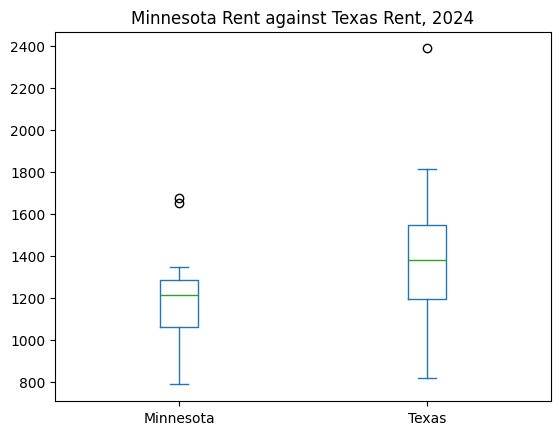

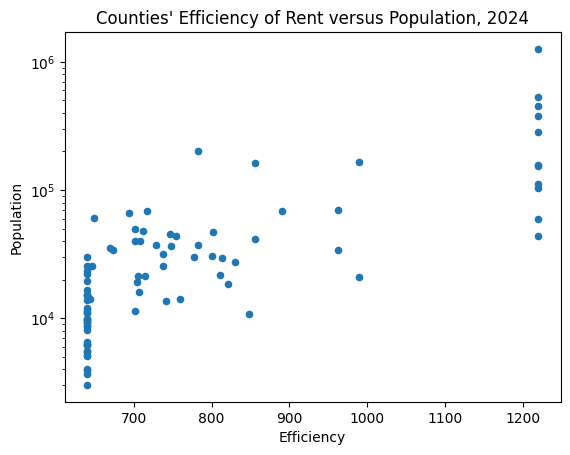

In [255]:
# marcus

# 1. Out of the two states I have chosen, if I am looking at the data of Texas compared to Minnesota, I will see a higher mean and more variation of rent because Texas is more economically active than the other.

# zillowrentals_MN contains historic data of all cities in the associated state
MN_current = zillowRentals_MN['2024-08-31']
TX_current = zillowRentals_TX['2024-08-31']

# combine then plot. boxplot will show all the descriptors we need
pandas.DataFrame({"Minnesota" : MN_current, "Texas" : TX_current}).plot(kind='box', title="Minnesota Rent against Texas Rent, 2024")

# in terms of the hypothesis, this is proven true. 
# the average of TX rent is much higher than the MN rent, as expected. The variation of rent can be shown by looking at the differences between IQ1 and IQ3, which are much farther apart in TX than MN. 

# 2. If Minnesota’s major cities have high rent, then there will be much lower rent outside of these cities because there is a lower standard of living comparatively.

# the best source for this will be huduser for county rent efficiency 
# get demographics by county (another data source, specific to the problem)
demographics_MN = pandas.read_csv('data/Demographics_MN.csv')
pop = demographics_MN.get(['pop2024', 'name'])
pop.rename(columns={'name': 'county_name', 'pop2024': 'Population'}, inplace=True)

# get counties into dataframe
counties_MN = pandas.DataFrame(pandas.json_normalize(countyInfo_MN))
counties_MN = counties_MN.merge(pop, on='county_name') # merge the demographics and county info

# plot in scatterplot: (Efficiency, Population)
print(counties_MN)
counties_MN.get(['county_name', "Efficiency", "Population"]).plot(kind='scatter', x='Efficiency', y="Population", logy=True, title="Counties' Efficiency of Rent versus Population, 2024")


In [163]:
# bharath